# Unsupervised Learning

In [70]:
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.impute import SimpleImputer
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, silhouette_score, v_measure_score, davies_bouldin_score
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import default_rng

pd.options.display.max_rows = 200
pd.options.display.max_info_columns = 200

In [95]:
# load train data
train_data = pd.read_parquet('dataset/1-GroupWiseMean/train_groupwise_mean_train_set.parquet')

# aggregrate train data
aggregate_functions = {}
for column in train_data.columns[2:]:
    aggregate_functions[column] = 'mean'

aggregate_train_data = train_data.groupby(train_data["customer_ID"], as_index=False).agg(aggregate_functions)

In [96]:
# load test data
test_data = pd.read_parquet('dataset/1-GroupWiseMean/train_groupwise_mean_test_set.parquet')

# aggregate test data
aggregate_functions = {}
for column in test_data.columns[2:]:
    aggregate_functions[column] = 'mean'

aggregate_test_data = test_data.groupby(test_data["customer_ID"], as_index=False).agg(aggregate_functions)

In [97]:
# impute the missing values with the mean of the features
pre_X = aggregate_train_data.iloc[:,1:].to_numpy()
pre_X[pre_X == -1] = np.nan

pre_Xtest = aggregate_test_data.iloc[:,1:].to_numpy()
pre_Xtest[pre_Xtest == -1] = np.nan

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(pre_X)
X = imp_mean.transform(pre_X)
Xtest = imp_mean.transform(pre_Xtest)

# normalize the data
X = preprocessing.normalize(X)
Xtest = preprocessing.normalize(Xtest)

In [98]:
all_train_labels = pd.read_csv('dataset/labels/train_labels.csv')

# train labels
customer_IDs = train_data['customer_ID'].unique()
train_labels = all_train_labels.loc[all_train_labels["customer_ID"].isin(customer_IDs)].reset_index(drop=True).copy()
Y = train_labels.iloc[:,1].to_numpy()

# test labels
customer_IDs = test_data['customer_ID'].unique()
test_labels = all_train_labels.loc[all_train_labels["customer_ID"].isin(customer_IDs)].reset_index(drop=True).copy()
Ytest = test_labels.iloc[:,1].to_numpy()

## PCA

In [109]:
# PCA
pca = PCA(n_components=0.99)
data_pca = pca.fit(X).transform(X)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.77312575 0.08541396 0.06436241 0.02422707 0.01981341 0.00804975
 0.00664749 0.00281656 0.00226722 0.00166455 0.00139148 0.00125833]


In [112]:
def plot_cumulative_pca_variances(variance_ratio: np.ndarray):
    plt.rcParams["figure.figsize"] = (12,6)

    length = variance_ratio.shape[0]

    fig, ax = plt.subplots()
    xi = np.arange(1, length+1, step=1)
    y = np.cumsum(variance_ratio*100)

    plt.ylim(0.0, 110)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('PCA Components', fontsize=16, labelpad=10)
    plt.ylabel('Cumulative variance (%)', fontsize=16)

    plt.xticks(np.arange(0, length+1, step=2))
    plt.yticks(np.arange(0, 110, step=20))
    plt.tick_params(axis="both",direction="in", pad=10)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')

    plt.axhline(y=99, color='r', linestyle='-')
    plt.text(0.5, 101, '99% cut-off threshold', color = 'red', fontsize=16)

    ax.grid(axis='both', alpha=0.5)
    plt.show()

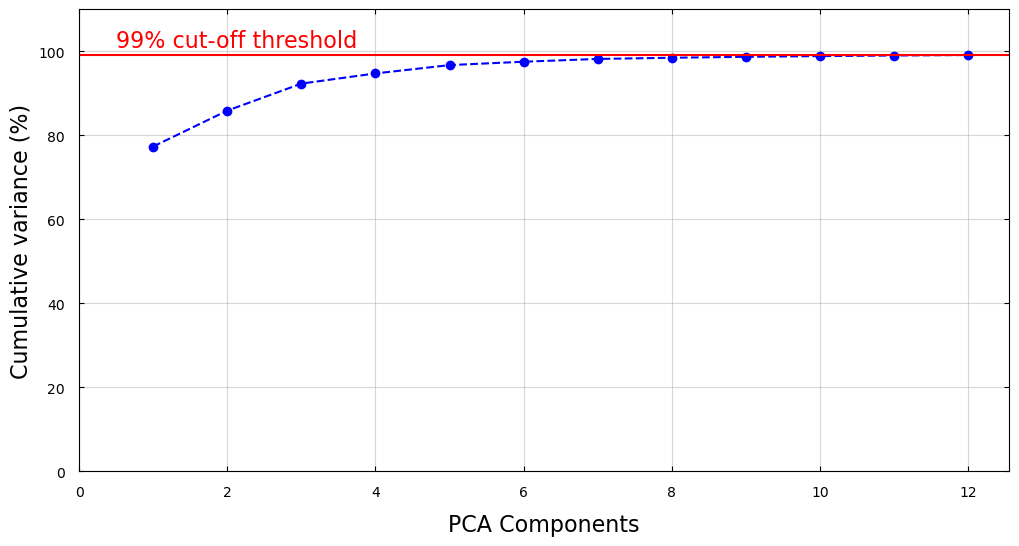

In [113]:
plot_cumulative_pca_variances(pca.explained_variance_ratio_)

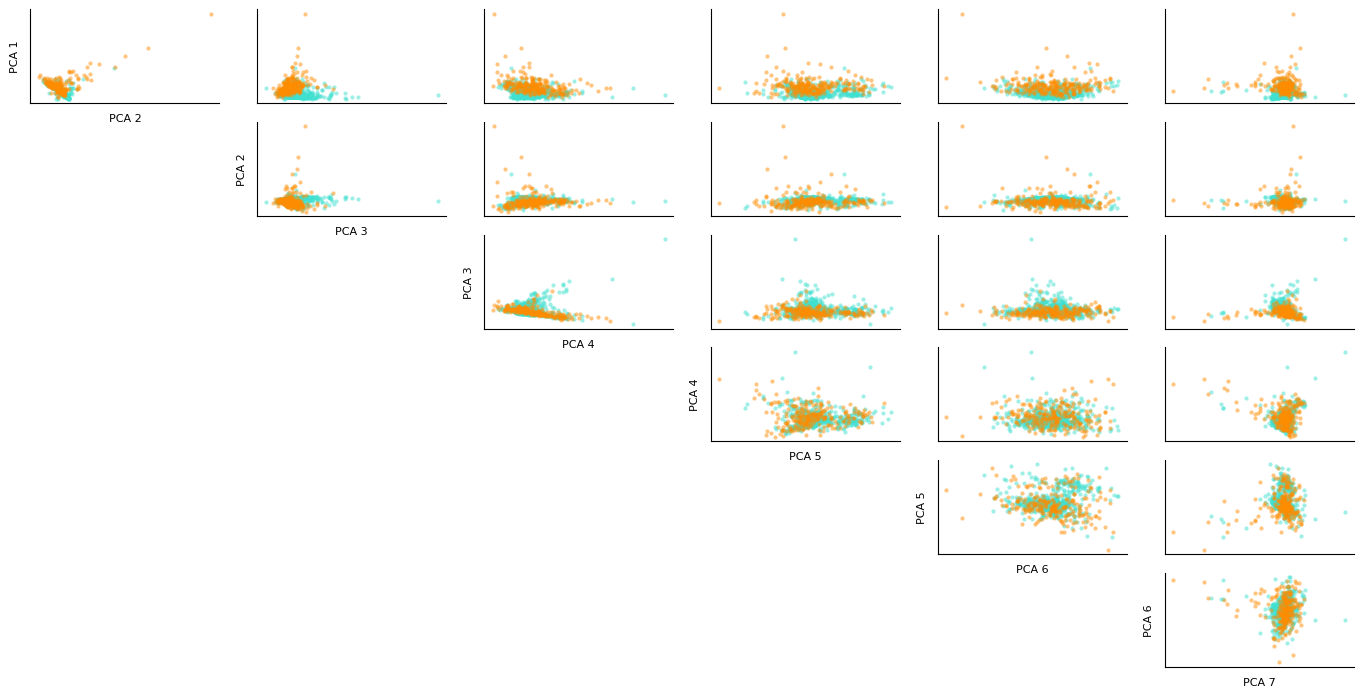

In [82]:
# sample the data to plot
rng = default_rng(seed=2)
idx = rng.choice(np.arange(X.shape[0]), size=1000, replace=False)
data = data_pca[idx]
label = Y[idx]

plt.rcParams["figure.figsize"] = (20,10)
components = 7
fig, axs = plt.subplots(components, components)
colors = ["turquoise", "darkorange"]

for r in range(components):
    for c in range(r+1, components):
        for color, i in zip(colors, [0, 1]):
            axs[r,c].scatter(
                data[label==i, c], data[label==i, r], 
                s=9, linewidths=0.0, alpha=0.5 ,color=color
            )
        if abs(c-r) == 1:
            axs[r,c].set_xlabel(f"PCA {c+1}", fontsize=8)
            axs[r,c].set_ylabel(f"PCA {r+1}", fontsize=8)

        axs[r,c].set_xticks([])
        axs[r,c].set_yticks([])
        axs[r,c].spines.right.set_visible(False)
        axs[r,c].spines.top.set_visible(False)

for r in range(components):
    for c in range(components):
        if r >= c:
            axs[r,c].set_visible(False)

plt.show()

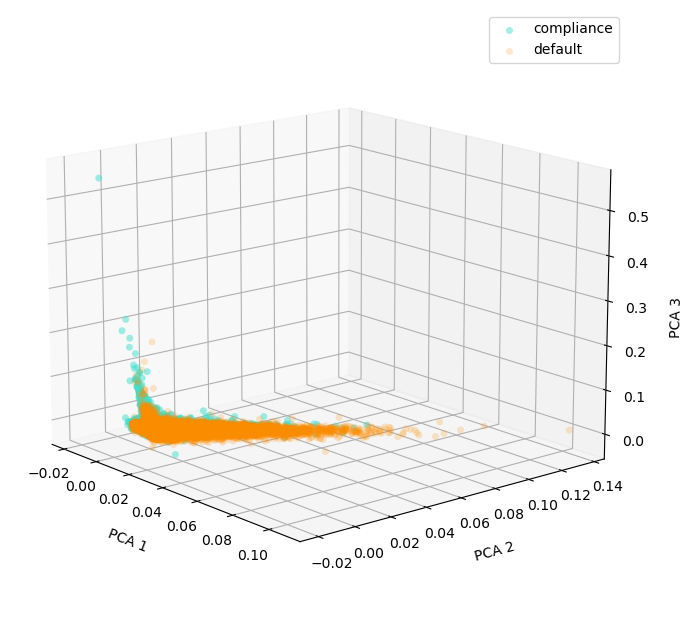

In [94]:
# sample the data to plot
rng = default_rng(seed=2)
idx = rng.choice(np.arange(X.shape[0]), size=1000, replace=False)
data = data_pca
label = Y

target_names = ["compliance", "default"]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")
colors = ["turquoise", "darkorange"]
alphas = [0.5, 0.2]

for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(
        data[label==i, 0], data[label==i, 1], data[label==i, 2],
        s=25, linewidths=0.0, alpha=alphas[i], color=color, label=target_name
    )

ax.set_xlabel("PCA 1", labelpad=10, rotation=0)
ax.set_ylabel("PCA 2", labelpad=10, rotation=0)
ax.set_zlabel("PCA 3", labelpad=7, rotation=0)

ax.legend(loc="best", shadow=False, scatterpoints=1)
ax.view_init(elev=15, azim=-40)

plt.show()

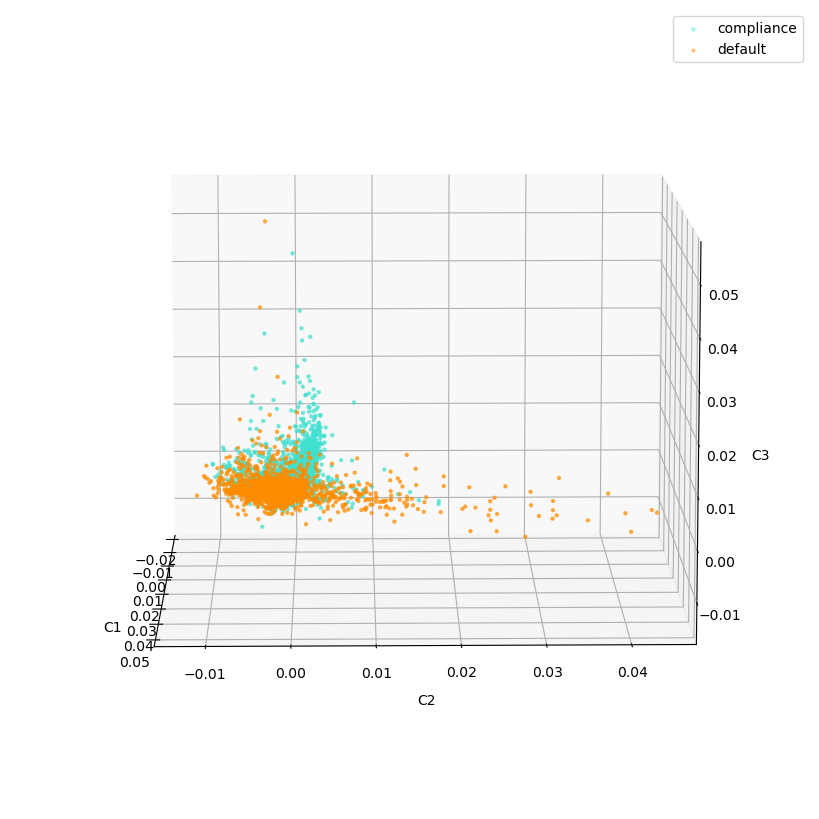

In [84]:
# sample the data to plot
rng = default_rng(seed=2)
idx = rng.choice(np.arange(X.shape[0]), size=5000, replace=False)
data = data_pca[idx]
label = Y[idx]

# Create a figure and a 3D Axes
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Create an init function and the animate functions.
def init():
    target_names = ["compliance", "default"]
    colors = ["turquoise", "darkorange"]

    for color, i, target_name in zip(colors, [0, 1], target_names):
        ax.scatter(
            data[label==i, 0], data[label==i, 1], data[label==i, 2],
            s=9, linewidths=0.0, alpha=0.5 ,color=color, label=target_name
        )

    return fig,


def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)

ax.set_xlabel("C1", labelpad=10)
ax.set_ylabel("C2", labelpad=10)
ax.set_zlabel("C3", labelpad=10)
ax.legend(loc="best", shadow=False, scatterpoints=1)

# Save
anim.save('images/pca/pca_projection_3D.gif', fps=30)

## t-SNE

In [76]:
rng = default_rng(seed=2)
idx = rng.choice(np.arange(X.shape[0]), size=10000, replace=False)
data = X[idx]
label = Y[idx]

data_embedded = TSNE(n_components=3, perplexity=40, learning_rate='auto', n_iter=500, init='random', verbose=1).fit_transform(data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.450s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.002858
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.959183
[t-SNE] KL divergence after 500 iterations: 1.967673


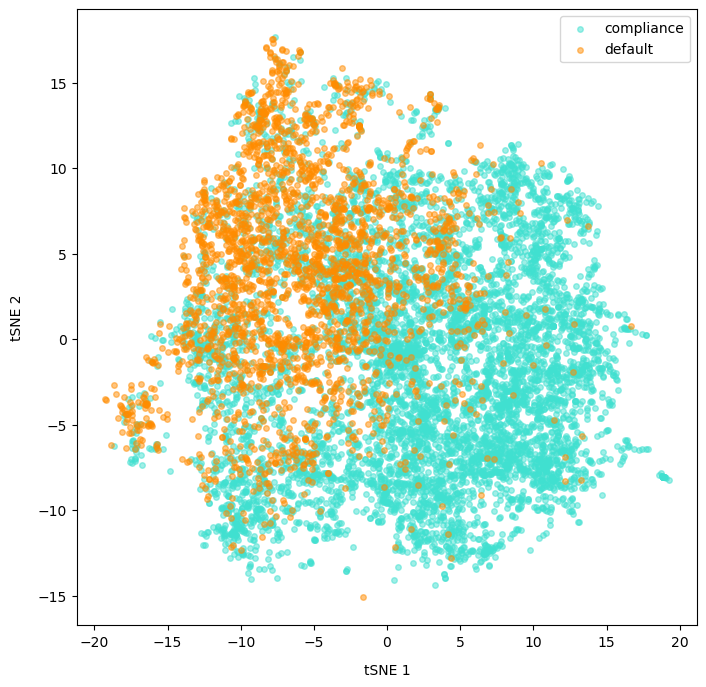

In [77]:
target_names = ["compliance", "default"]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
colors = ["turquoise", "darkorange"]
marker_sizes = [16, 16]

for color, i, ms, target_name in zip(colors, [0, 1], marker_sizes, target_names):
    ax.scatter(
        data_embedded[label==i, 1], data_embedded[label==i, 0], s=ms, alpha=0.5 ,color=color, label=target_name
    )

ax.set_xlabel("tSNE 1", labelpad=10)
ax.set_ylabel("tSNE 2", labelpad=10)
ax.legend(loc="best", shadow=False, scatterpoints=1)

plt.show()

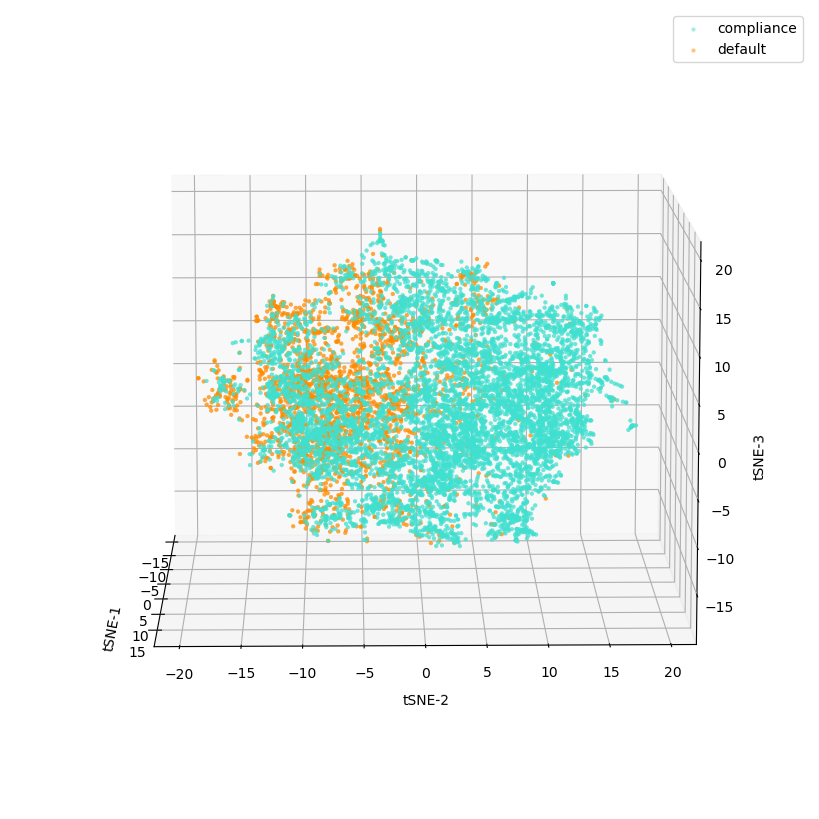

In [78]:
# Create a figure and a 3D Axes
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Create an init function and the animate functions.
def init():
    target_names = ["compliance", "default"]
    colors = ["turquoise", "darkorange"]

    for color, i, target_name in zip(colors, [0, 1], target_names):
        ax.scatter(
            data_embedded[label==i, 0], data_embedded[label==i, 1], data_embedded[label==i, 2],
            s=9, linewidths=0.0, alpha=0.5 ,color=color, label=target_name
        )

    return fig,


def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)

ax.set_xlabel("tSNE-1", labelpad=10)
ax.set_ylabel("tSNE-2", labelpad=10)
ax.set_zlabel("tSNE-3", labelpad=10)
ax.legend(loc="best", shadow=False, scatterpoints=1)

# Save
anim.save('images/tsne/tsne_projection_3D_emma.gif', fps=30)

## KMeans

In [63]:
x = data_pca
kmeans = KMeans(n_clusters=2).fit(x)

In [64]:
ypredict = kmeans.labels_
ytruth = Y

# determine which cluster predict which labels
n00 = np.sum(np.logical_and(ypredict==0, ytruth==0))
n01 = np.sum(np.logical_and(ypredict==0, ytruth==1))
n10 = np.sum(np.logical_and(ypredict==1, ytruth==0))
n11 = np.sum(np.logical_and(ypredict==1, ytruth==1))

table = pd.DataFrame(data=np.array([[n00, n01], [n10, n11]]), columns=["Label 0", "Label 1"], index=["Cluster 0", "Cluster 1"])
table

,Label 0,Label 1
Cluster 0,45397,79074
Cluster 1,287365,36201


In [65]:
print(f"{n00/(n00+n01)} of cluster 0 vote for compliance (label 0), {n01/(n00+n01)} of cluster 0 vote for default (label 1)")
print(f"{n10/(n10+n11)} of cluster 1 vote for compliance (label 0), {n11/(n10+n11)} of cluster 0 vote for default (label 1)")

0.3647194928939271 of cluster 0 vote for compliance (label 0), 0.6352805071060729 of cluster 0 vote for default (label 1)
0.8881186527632693 of cluster 1 vote for compliance (label 0), 0.11188134723673068 of cluster 0 vote for default (label 1)


Cluster 0 votes for default (label 1); Cluster 1 vote for compliance (label 0)

In [71]:
silhouette = silhouette_score(x, ypredict, sample_size=10000, random_state=1)
print("silhouette score: ", silhouette)

beta_cv = v_measure_score(ytruth, ypredict)
print("beta-cv score: ", beta_cv)

davies_bouldin = davies_bouldin_score(x, ypredict)
print('davies bouldin score: ', davies_bouldin)

silhouette score:  0.23026240338342235
beta-cv score:  0.23229467302308177
davies bouldin score:  2.6359377851173127


In [45]:
# external evaluation
xtest = pca.transform(Xtest)
ypredict = kmeans.predict(xtest) ^ 1
ytruth = Ytest

In [40]:
def purities(model_labels: np.ndarray, ground_truths: np.ndarray):
    # Calculating purity value
    size_cluster0 = np.sum(model_labels==0)
    n00 = np.sum(np.logical_and(model_labels==0, ground_truths==0))
    n01 = np.sum(np.logical_and(model_labels==0, ground_truths==1))
    purity_cluster0 = max(n00,n01)/size_cluster0
    print("Purity of cluster 0 is ", purity_cluster0)

    size_cluster1 = np.sum(model_labels==1)
    n10 = np.sum(np.logical_and(model_labels==1, ground_truths==0))
    n11 = np.sum(np.logical_and(model_labels==1, ground_truths==1))
    purity_cluster1 = max(n10,n11)/size_cluster1
    print("Purity of cluster 1 is ", purity_cluster1)

    n = size_cluster0 + size_cluster1
    total_purity = size_cluster0/n * purity_cluster0 + size_cluster1/n * purity_cluster1
    print("Total purity is ", total_purity)

    cm = pd.DataFrame(data=np.array([[n00, n01], [n10, n11]]), columns=["Label 0", "Label 1"], index=["Cluster 0", "Cluster 1"])
    print("Confusion matrix:\n", cm)

    return (n00, n01, n10, n11)

In [46]:
n00, n01, n10, n11 = purities(ypredict, ytruth)

Purity of cluster 0 is  0.9154580427178048
Purity of cluster 1 is  0.690082019309343
Total purity is  0.8505511937992605
Confusion matrix:
            Label 0  Label 1
Cluster 0   299125    27624
Cluster 1    40960    91204


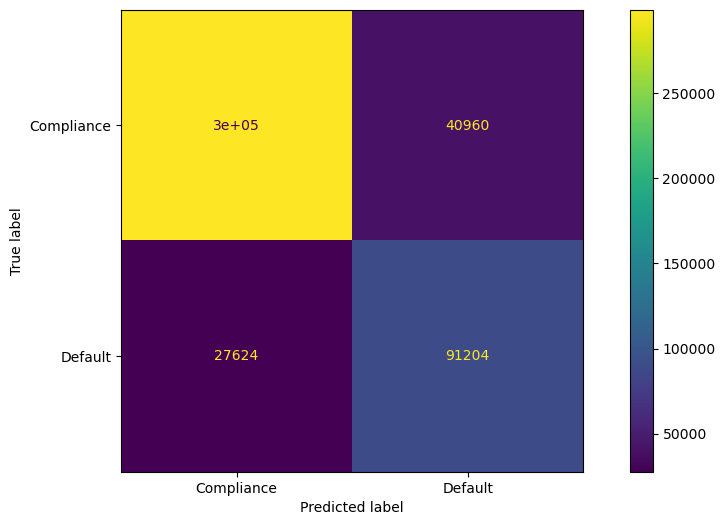

In [47]:
plt.rcParams["figure.figsize"] = (12,6)
cm = confusion_matrix(ytruth, ypredict)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Compliance", "Default"])
cm_display.plot()
plt.show()

In [48]:
# Precision, Recall, Accuracy, F-measure
# Cluster 0 will correspond to the class label 1 or "Default"
# Cluster 1 will correspond to the class label 0 or "Compliance"
true_positive = n00
false_positive = n01
false_negative = n10
true_negative = n11

print("For cluster 0 / Compliance label:")
precision = true_positive / (true_positive + false_positive)
print("     The precision score is ", precision)
recall = true_positive / (true_positive + false_negative)
print("     The recall score is ", recall)
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
print("     The accuracy score is ", accuracy)
fmeasure = 2/(1/precision + 1/recall)
print("     F-Measure: ", fmeasure)

print("\n")
print("For cluster 1 / Default label:")
precision = true_negative / (true_negative + false_negative)
print("     The precision score is ", precision)
recall = true_negative / (true_negative + false_positive)
print("     The recall score is ", recall)
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
print("     The accuracy score is ", accuracy)
fmeasure = 2/(1/precision + 1/recall)
print("     F-Measure: ", fmeasure)

For cluster 0 / Compliance label:
     The precision score is  0.9154580427178048
     The recall score is  0.8795595218842348
     The accuracy score is  0.8505511937992605
     F-Measure:  0.8971498153963355


For cluster 1 / Default label:
     The precision score is  0.690082019309343
     The recall score is  0.7675295384926112
     The accuracy score is  0.8505511937992605
     F-Measure:  0.7267482628928412


In [ ]:
x = 

## GMM

In [72]:
x = data_pca
gmm = GaussianMixture(n_components=2, covariance_type='full', init_params='kmeans', random_state=2, verbose=1).fit(x)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


In [73]:
ypredict = gmm.predict(x)
ytruth = Y

# determine which cluster predict which labels
n00 = np.sum(np.logical_and(ypredict==0, ytruth==0))
n01 = np.sum(np.logical_and(ypredict==0, ytruth==1))
n10 = np.sum(np.logical_and(ypredict==1, ytruth==0))
n11 = np.sum(np.logical_and(ypredict==1, ytruth==1))

table = pd.DataFrame(data=np.array([[n00, n01], [n10, n11]]), columns=["Label 0", "Label 1"], index=["Cluster 0", "Cluster 1"])
table

,Label 0,Label 1
Cluster 0,9305,22504
Cluster 1,323457,92771


In [74]:
print(f"{n00/(n00+n01)} of cluster 0 vote for compliance (label 0), {n01/(n00+n01)} of cluster 0 vote for default (label 1)")
print(f"{n10/(n10+n11)} of cluster 1 vote for compliance (label 0), {n11/(n10+n11)} of cluster 0 vote for default (label 1)")

0.2925272721556792 of cluster 0 vote for compliance (label 0), 0.7074727278443208 of cluster 0 vote for default (label 1)
0.7771149466157972 of cluster 1 vote for compliance (label 0), 0.2228850533842029 of cluster 0 vote for default (label 1)


Cluster 0 votes for the default label, while cluster 1 votes for compliance

In [75]:
# internal evaluation
silhouette = silhouette_score(x, ypredict, sample_size=10000, random_state=1)
print("silhouette score: ", silhouette)

beta_cv = v_measure_score(ytruth, ypredict)
print("beta-cv score: ", beta_cv)

davies_bouldin = davies_bouldin_score(x, ypredict)
print('davies bouldin score: ', davies_bouldin)

silhouette score:  0.49981210934489556
beta-cv score:  0.08330678327822572
davies bouldin score:  3.32036001423303


In [58]:
# external evaluation
xtest = pca.transform(Xtest)
ypredict = gmm.predict(xtest) ^ 1
ytruth = Ytest

In [59]:
n00, n01, n10, n11 = purities(ypredict, ytruth)

Purity of cluster 0 is  0.7847686112418214
Purity of cluster 1 is  0.7721743960011108
Total purity is  0.7837803679564536
Confusion matrix:
            Label 0  Label 1
Cluster 0   331881    91022
Cluster 1     8204    27806


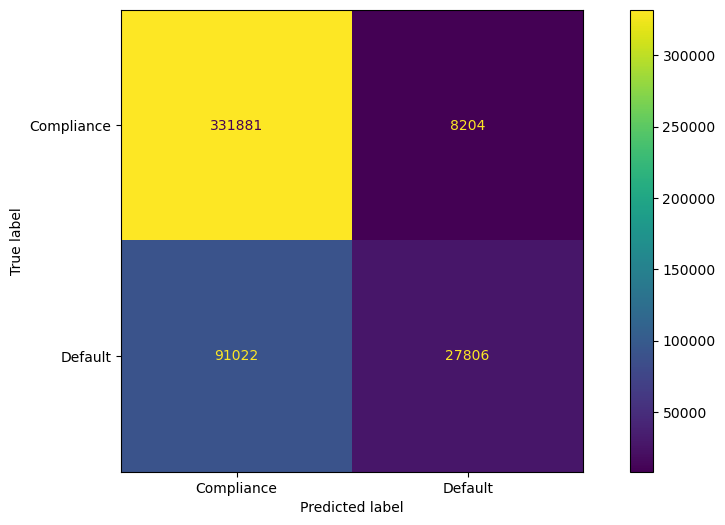

In [61]:
plt.rcParams["figure.figsize"] = (12,6)
cm = confusion_matrix(ytruth, ypredict)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Compliance", "Default"])
cm_display.plot()
plt.show()

In [62]:
# Precision, Recall, Accuracy, F-measure
# Cluster 0 will correspond to the class label 1 or "Default"
# Cluster 1 will correspond to the class label 0 or "Compliance"
true_positive = n00
false_positive = n01
false_negative = n10
true_negative = n11

print("For cluster 0 / Compliance label:")
precision = true_positive / (true_positive + false_positive)
print("     The precision score is ", precision)
recall = true_positive / (true_positive + false_negative)
print("     The recall score is ", recall)
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
print("     The accuracy score is ", accuracy)
fmeasure = 2/(1/precision + 1/recall)
print("     F-Measure: ", fmeasure)

print("\n")
print("For cluster 1 / Default label:")
precision = true_negative / (true_negative + false_negative)
print("     The precision score is ", precision)
recall = true_negative / (true_negative + false_positive)
print("     The recall score is ", recall)
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
print("     The accuracy score is ", accuracy)
fmeasure = 2/(1/precision + 1/recall)
print("     F-Measure: ", fmeasure)

For cluster 0 / Compliance label:
     The precision score is  0.7847686112418214
     The recall score is  0.975876619080524
     The accuracy score is  0.7837803679564537
     F-Measure:  0.8699507724892136


For cluster 1 / Default label:
     The precision score is  0.7721743960011108
     The recall score is  0.23400208705019018
     The accuracy score is  0.7837803679564537
     F-Measure:  0.3591624794946977
